In [0]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = 'cs231n/assignments/assignment1/cs231n/'

# symlink to make it easier to load your files
!ln -s "/content/drive/My Drive/$FOLDERNAME" "/content/assignment1"

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content
/content/cs231n/datasets
--2020-04-23 04:41:28--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  58.2MB/s    in 2.8s    

2020-04-23 04:41:31 (58.2 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content


# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [0]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


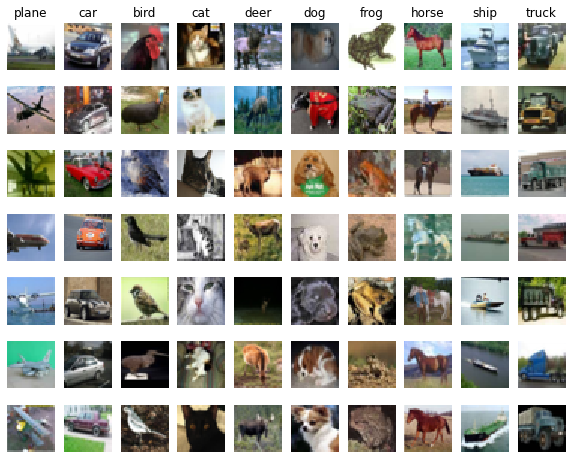

In [0]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [0]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing  
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [0]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


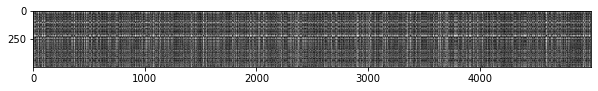

In [0]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ 

- Since we are working with pixel intensity values, distinctly bright rows indicate a significant delta in pixel intensities between the corresponding test and training images (say a black background being "compared" to a white background and vice-versa). While foreground differences can obviously contribute to pixel deltas, in some cases the background of an image can be a relatively huge proportion of the image which can heavily contribute to a significant pixel-level delta. For the case of distinctly bright rows, we can infer that for the particular test image corresponding to that row, the test images' contents have a distinctly different foreground/background that leads to a significantly large pixel delta. Similarly, the distinctly bright columns can be due to a particular train image having content that does not match the test images.

- For e.g., consider an image which has a cat in the center of the image on a white background. If the other images that this image is being compared against have black backgrounds, this will cause a large pixel-wise distance between the two images.


In [0]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [0]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$ 1, 2, 3


$\color{blue}{\textit Your Explanation:}$

1. Subtracting the mean $\mu$ from the data does have the conditioning effect of centering the data around the origin. However, in our case since we are dealing with images, the feature ranges are aleady localized, i.e., all pixels lie within [0-255]. Subtracting the mean will only offset the pixel values and will likely not have a drastic effect on the performance of the Nearest Neighbour classifier. To demonstrate this mathematically, the distance between a given test sample over each sample in the training set is given by,

$$L_{1}=\frac{1}{n} \sum_{k=1}^n ||\,(x_{test} - \mu) - (x_{train}^{(k)} - \mu)\,||_{1} = ||\,x_{test} - x_{train}^{(k)}\,||_{1}$$

Here, $x_{test}$ and $x_{train}^{k}$ are vectors that hold a test and the $k^{th}$ training image. 

2. Subtracting the per-pixel mean $\mu_{ij}$ from the data also has the conditioning effect of centering the data around the origin. However, as explained above, since all pixel values are already localized to [0-255], it wouldn't impact the performance of the classifier. Similar to (1) above, to demonstrate this mathematically, the distance between a test and $k^{th}$ training sample is given by,

$$L_{1}=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w} ||\,(p_{ij} - \mu_{ij}) - (q_{ij}^{(k)} - \mu_{ij})\,||_{1} = ||\,p_{ij} - q_{ij}^{(k)}\,||_{1}$$

Here, $p_{ij}$ and $q_{ij}^{(k)}$ are the pixels at $(i,j)$ within the test image and the $k^{th}$ training image respectively. 

3. 
- Subtracting the mean and dividing by the standard deviation would yield zero-centered data ($\mu$ = 0) with unit variance ($\sigma$ = 1), i.e., properties of a standard normal distribution. This pre-processing step would normally be very useful if different features/dimensions of the data had different ranges, e.g., if feature #1 has a range [-1000-1000] and feature #2 has a range of [0-1], feature #1 will have more impact in the calculation of distances because of the order of magnitude difference between the two features. In such cases where there is a stark delta in the features ranges, normalization is key. However, in our case since we are dealing with images, the feature ranges are mostly similar, i.e., all pixels lie within [0-255] and there is no feature scale mismatch. The benefits of normalization are limited in our specific case due to the fact that we have an image dataset. 

- In this case, since we are using the standard deviation calculated over all pixels uniformly, the L1 distance is effectively just being scaled by a fixed factor. This would cause the nearest neighbors of a point to remain the same and thus would not affect the performance of the classifier. 

- Performing feature scaling does help facilitate learning by bounding the gradients and thus making gradient descent converge faster and speed up training, but this does not affect classifier accuracy. 

4. Since we are dividing by the pixel-wise standard deviation $\sigma_{ij}$, we are scaling different dimensions differently. The nearest neighbors could thus change and this would in turn affect the performance of the classifier.

5. There are two cases:

(i) Assuming we are rotating the co-ordinate axes of the L1 classifier:

L1 distance is not invariant to the rotation of the coordinate axes, unlike L2. The distance between points changes with the rotation of axes and thus, the performance of the classifier can potentially be affected. To demonstrate this mathematically, consider that the coordinate axes of the data (in red) are rotated 45 degrees (or by pi/4 radians) in the counter-clockwise direction (in blue), illustrated in the diagram below.

![l1distrotation](https://github.com/amanchadha/stanford-cs231n-2020/blob/master/assignment1/L1distrotation.jpeg?raw=true)

Lets consider three points x = (0, 1), y = (1, 0) and z = (1, -2). The L1-distance between the three points with y as pivot would be,

$$\begin{align*}\Vert x - y\Vert_1&=\Vert y-z\Vert_1=2\end{align*}$$

This implies that both x and z are at the same distance from y. 
Now consider the 45 degrees rotation matrix:

<!-- $$\begin{align*}\left[ {\begin{array}{*{20}{c}}
{\frac{1}{{\sqrt 2 }}}&{\frac{{ - 1}}{{\sqrt 2 }}}\\
{\frac{1}{{\sqrt 2 }}}&{\frac{1}{{\sqrt 2 }}}
\end{array}} \right]\end{align*}$$ -->

![alt text](https://latex.codecogs.com/png.latex?%5Cdpi%7B110%7D%20%5Clarge%20%5Cbegin%7Balign*%7D%5Cleft%5B%20%7B%5Cbegin%7Barray%7D%7B*%7B20%7D%7Bc%7D%7D%20%7B%5Cfrac%7B1%7D%7B%7B%5Csqrt%202%20%7D%7D%7D%26%7B%5Cfrac%7B%7B%20-%201%7D%7D%7B%7B%5Csqrt%202%20%7D%7D%7D%5C%5C%20%7B%5Cfrac%7B1%7D%7B%7B%5Csqrt%202%20%7D%7D%7D%26%7B%5Cfrac%7B1%7D%7B%7B%5Csqrt%202%20%7D%7D%7D%20%5Cend%7Barray%7D%7D%20%5Cright%5D%5Cend%7Balign*%7D)

Then, the new co-ordinates after the 45 degrees rotation would be given by,

<!-- \begin{align*}\left[ {\begin{array}{*{20}{c}}
{\frac{1}{{\sqrt 2 }}}&{\frac{{ - 1}}{{\sqrt 2 }}}\\
{\frac{1}{{\sqrt 2 }}}&{\frac{1}{{\sqrt 2 }}}
\end{array}} \right]\left[ {\begin{array}{*{20}{c}}
x\\
y
\end{array}} \right]\end{align*} -->

![alt text](https://latex.codecogs.com/png.latex?%5Cdpi%7B110%7D%20%5Clarge%20%5Cbegin%7Balign*%7D%5Cleft%5B%20%7B%5Cbegin%7Barray%7D%7B*%7B20%7D%7Bc%7D%7D%20%7B%5Cfrac%7B1%7D%7B%7B%5Csqrt%202%20%7D%7D%7D%26%7B%5Cfrac%7B%7B%20-%201%7D%7D%7B%7B%5Csqrt%202%20%7D%7D%7D%5C%5C%20%7B%5Cfrac%7B1%7D%7B%7B%5Csqrt%202%20%7D%7D%7D%26%7B%5Cfrac%7B1%7D%7B%7B%5Csqrt%202%20%7D%7D%7D%20%5Cend%7Barray%7D%7D%20%5Cright%5D%5Cleft%5B%20%7B%5Cbegin%7Barray%7D%7B*%7B20%7D%7Bc%7D%7D%20x%5C%5C%20y%20%5Cend%7Barray%7D%7D%20%5Cright%5D%5Cend%7Balign*%7D)

Thus, x, y and z get transformed to x', y' and z' as follows,
<!-- \begin{align*}x'&=Ax\\&=\left[\begin{array}{c}-\frac{1}{\sqrt{2}}\\\frac{1}{\sqrt{2}}\end{array}\right]\\y'&=Ay\\&=\left[\begin{array}{c}\frac{1}{\sqrt{2}}\\\frac{1}{\sqrt{2}}\end{array}\right]\\z'&=Az\\&=\left[\begin{array}{c}\frac{3}{\sqrt{2}}\\-\frac{1}{\sqrt{2}}\end{array}\right]\end{align*} -->

![alt text](https://latex.codecogs.com/png.latex?%5Cdpi%7B110%7D%20%5Clarge%20%5Cbegin%7Balign*%7Dx%27%26%3DAx%5C%5C%26%3D%5Cleft%5B%5Cbegin%7Barray%7D%7Bc%7D-%5Cfrac%7B1%7D%7B%5Csqrt%7B2%7D%7D%5C%5C%5Cfrac%7B1%7D%7B%5Csqrt%7B2%7D%7D%5Cend%7Barray%7D%5Cright%5D%5C%5Cy%27%26%3DAy%5C%5C%26%3D%5Cleft%5B%5Cbegin%7Barray%7D%7Bc%7D%5Cfrac%7B1%7D%7B%5Csqrt%7B2%7D%7D%5C%5C%5Cfrac%7B1%7D%7B%5Csqrt%7B2%7D%7D%5Cend%7Barray%7D%5Cright%5D%5C%5Cz%27%26%3DAz%5C%5C%26%3D%5Cleft%5B%5Cbegin%7Barray%7D%7Bc%7D%5Cfrac%7B3%7D%7B%5Csqrt%7B2%7D%7D%5C%5C-%5Cfrac%7B1%7D%7B%5Csqrt%7B2%7D%7D%5Cend%7Barray%7D%5Cright%5D%5Cend%7Balign*%7D)

The new L1-distance between the three points (again, with y as pivot) is,
<!-- \begin{align*}\Vert x'-y'\Vert_1&=\sqrt{2}\\\Vert y'-z'\Vert_1&=\frac{3}{\sqrt{2}}\end{align*} -->

![alt text](https://latex.codecogs.com/png.latex?%5Cdpi%7B100%7D%20%5Clarge%20%5Cbegin%7Balign*%7D%5CVert%20x%27-y%27%5CVert_1%26%3D%5Csqrt%7B2%7D%5C%5C%5CVert%20y%27-z%27%5CVert_1%26%3D%5Cfrac%7B3%7D%7B%5Csqrt%7B2%7D%7D%5Cend%7Balign*%7D)

and thus, <!-- $\Vert x'-y'\Vert_1<\Vert y'-z'\Vert_1$.--> 

![alt text](https://latex.codecogs.com/png.latex?%5Cinline%20%5Cdpi%7B120%7D%20%5Clarge%20%24%5CVert%20x%27-y%27%5CVert_1%3C%5CVert%20y%27-z%27%5CVert_1%24)

Hence, ordering is not preserved with L1 distance post rotation.

(ii) Assuming we are rotating the co-ordinate axes of the data (images):

With the assumption that there is no data loss (sufficient padding), the classifier performance will not change.


In [0]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [0]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [0]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 35.387777 seconds
One loop version took 30.430853 seconds
No loop version took 0.516027 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [0]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for current_k in k_choices:
    k_to_accuracies[current_k] = []
    
    for validation_fold in range(num_folds):
        classifier = KNearestNeighbor() # create a new classifier object

        # concatenate together all other folds in X_train_folds apart from the validation fold 
        # and train the classifier
        classifier.train(np.concatenate(X_train_folds[:validation_fold] + X_train_folds[validation_fold + 1:]), 
                         np.concatenate(y_train_folds[:validation_fold] + y_train_folds[validation_fold + 1:])) 

        y_pred_fold = classifier.predict(X_train_folds[validation_fold], k = current_k)

        k_to_accuracies[current_k].append(np.mean(y_pred_fold == y_train_folds[validation_fold]))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

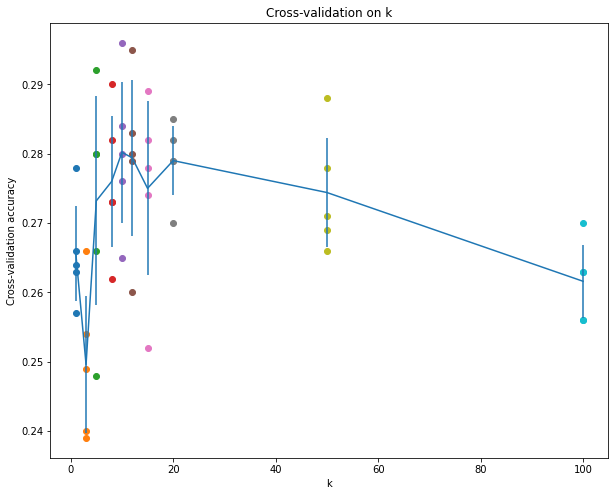

In [0]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [0]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = k_choices[accuracies_mean.argmax()]

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$ 2 and 4.


$\color{blue}{\textit Your Explanation:}$

1. False. The decision boundary of the k-NN classifier is not linear. If you consider a dataset where the classes belong to concentric circles, the decision boundaries in this case will follow the curvature of the concentric circles.

2. True. The training error of a 1-NN will always be lower than that of 5-NN because for each training example, its nearest neighbor is always going to be itself, i.e., error of 1-NN will be zero.

3. False. The test error of a 1-NN will not always be lower than 5-NN. Lets consider an example. Suppose $x_{train} = (1,2,3,4,5)$ and $y_{train} = (1,0,0,0,0)$. For a test sample of $x = 0$ with $y = 0$, $y_{pred}$ would be 1 for 1-NN (thus, error = 100%) while $y_{pred}$ would be 0 for 5-NN (thus, error = 0%). The value of $k$ is thus data-dependent, which is why we need to perform cross validation to determine the best $k$ for your intended application and dataset.

4. True. The testing phase of k-NN is essentially performing comparisons of each test sample with the entire training set, which needs one full pass through the training set. Infact, the training phase of k-NN, which consists of remembering the traning set would also grow with the size of the training set. However, in order to decrease the number of comparisons and thus improve time complexity, we can use Approximate Nearest Neighbor techniques (such as k-d trees, ball trees etc.).


---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [0]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['cs231n/classifiers/k_nearest_neighbor.py']

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))